<a href="https://colab.research.google.com/github/jamissonfreitas/IN1167/blob/master/ML/emsemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

In [0]:
url='https://raw.githubusercontent.com/FinYang/tsdl/master/data-raw/commod/gold.dat'
s = requests.get(url).content
data = ' '.join([l.strip() for l in s.decode('utf-8').split('\n')[1:]])
serie = pd.Series(
    data.split(' '),
    index=pd.date_range(start ='1-1-1997', end ='4-7-1997', freq ='D')
)

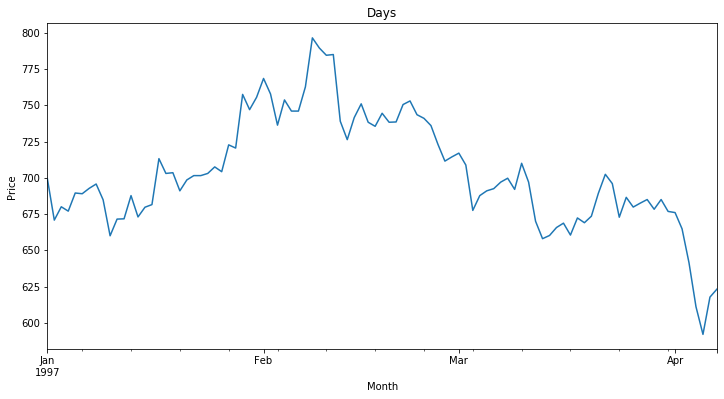

In [18]:
H = 6
V = 12
serie = serie.astype(float)
serie.plot(figsize=(V,H))
plt.title('Days')
plt.ylabel('Price')
plt.xlabel('Month')
plt.show()

# Normalization

In [0]:
def normalizar_serie(serie):
    minimo = min(serie)
    maximo = max(serie)
    y = (serie - minimo) / (maximo - minimo)
    return y
    
def desnormalizar(serie_atual, serie_real):
    minimo = min(serie_real)
    maximo = max(serie_real)
    
    serie = (serie_atual * (maximo - minimo)) + minimo
    
    return pd.DataFrame(s)

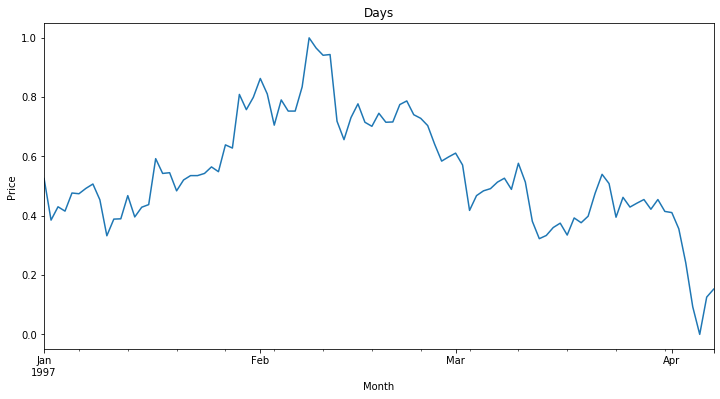

In [20]:
serie_normalizada = normalizar_serie(serie)

serie_normalizada.plot(figsize=(V,H))
plt.title('Days')
plt.ylabel('Price')
plt.xlabel('Month')
plt.show()


# Lag choice

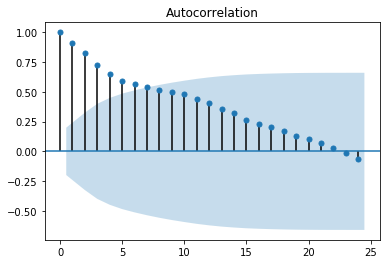

In [21]:
plot_acf(serie_normalizada, lags=24)
plt.show()

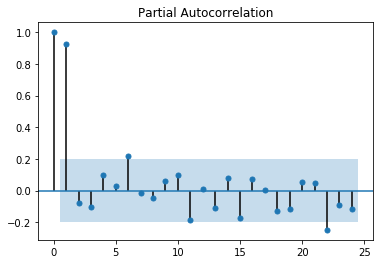

In [22]:
plot_pacf(serie_normalizada, lags=24)
plt.show()

# Data preparation

In [0]:
def select_lag_acf(serie, max_lag):
    from statsmodels.tsa.stattools import acf
    x = serie[0: max_lag+1]
    
    acf_x, confint = acf(serie, nlags=max_lag, alpha=.05, fft=False,
                             unbiased=False)
       
    limiar_superior = confint[:, 1] - acf_x
    limiar_inferior = confint[:, 0] - acf_x
    
    lags_selecionados = []
    
    for i in range(1, max_lag+1):

        
        if acf_x[i] >= limiar_superior[i] or acf_x[i] <= limiar_inferior[i]:
            lags_selecionados.append(i-1)  #-1 por conta que o lag 1 em python é o 0
    
    #caso nenhum lag seja selecionado, essa atividade de seleção para o gridsearch encontrar a melhor combinação de lags
    if len(lags_selecionados)==0:


        print('NENHUM LAG POR ACF')
        lags_selecionados = [i for i in range(max_lag)]

    print('LAGS', lags_selecionados)

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #inverte o valor dos lags para usar na lista de dados se os dados forem de ordem [t t+1 t+2 t+3]
    lags_selecionados = [max_lag - (i+1) for i in lags_selecionados]
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    return lags_selecionados

In [24]:
tam_janela = 10
lag_sel = select_lag_acf(serie_normalizada, tam_janela)
lag_sel

LAGS [0, 1, 2, 3, 4, 5, 6]


[9, 8, 7, 6, 5, 4, 3]

In [0]:
def gerar_janelas(tam_janela, serie):
    # serie: vetor do tipo numpy ou lista
    tam_serie = len(serie)
    tam_janela = tam_janela +1 # Adicionado mais um ponto para retornar o target na janela
    
    janela = list(serie[0:0+tam_janela]) #primeira janela p criar o objeto np
    janelas_np = np.array(np.transpose(janela))    
       
    for i in range(1, tam_serie-tam_janela):
        janela = list(serie[i:i+tam_janela])
        j_np = np.array(np.transpose(janela))        
        
        janelas_np = np.vstack((janelas_np, j_np))
        
    
    return janelas_np

In [26]:
serie_janelas = gerar_janelas(tam_janela, serie_normalizada)
serie_janelas

array([[0.52567237, 0.38533007, 0.43031785, 0.41564792, 0.47677262,
        0.47432763, 0.49242054, 0.50709046, 0.45378973, 0.33251834,
        0.38875306],
       [0.38533007, 0.43031785, 0.41564792, 0.47677262, 0.47432763,
        0.49242054, 0.50709046, 0.45378973, 0.33251834, 0.38875306,
        0.38973105],
       [0.43031785, 0.41564792, 0.47677262, 0.47432763, 0.49242054,
        0.50709046, 0.45378973, 0.33251834, 0.38875306, 0.38973105,
        0.46797066],
       [0.41564792, 0.47677262, 0.47432763, 0.49242054, 0.50709046,
        0.45378973, 0.33251834, 0.38875306, 0.38973105, 0.46797066,
        0.39608802],
       [0.47677262, 0.47432763, 0.49242054, 0.50709046, 0.45378973,
        0.33251834, 0.38875306, 0.38973105, 0.46797066, 0.39608802,
        0.42885086],
       [0.47432763, 0.49242054, 0.50709046, 0.45378973, 0.33251834,
        0.38875306, 0.38973105, 0.46797066, 0.39608802, 0.42885086,
        0.43765281],
       [0.49242054, 0.50709046, 0.45378973, 0.33251834, 0.

In [0]:
def split_serie_with_lags(serie, perc_train, perc_val = 0):
    
    #faz corte na serie com as janelas já formadas 
    
    x_date = serie[:, 0:-1]
    y_date = serie[:, -1]        
       
    train_size = np.fix(len(serie) *perc_train)
    train_size = train_size.astype(int)
    
    if perc_val > 0:        
        val_size = np.fix(len(serie) *perc_val).astype(int)
              
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]
        print("Particao de Treinamento:", 0, train_size  )
        
        x_val = x_date[train_size:train_size+val_size,:]
        y_val = y_date[train_size:train_size+val_size]
        
        print("Particao de Validacao:",train_size, train_size+val_size)
        
        x_test = x_date[(train_size+val_size):-1,:]
        y_test = y_date[(train_size+val_size):-1]
        
        print("Particao de Teste:", train_size+val_size, len(y_date))
        
        return x_train, y_train, x_test, y_test, x_val, y_val
        
    else:
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]

        x_test = x_date[train_size:-1,:]
        y_test = y_date[train_size:-1]

        return x_train, y_train, x_test, y_test

In [28]:
x_train, y_train, x_test, y_test, x_val, y_val = split_serie_with_lags(serie_janelas, 0.5, perc_val = 0.25)

Particao de Treinamento: 0 43
Particao de Validacao: 43 64
Particao de Teste: 64 86


In [0]:
train_size = len(y_train)
val_size = len(y_val)
test_size = len(y_test)

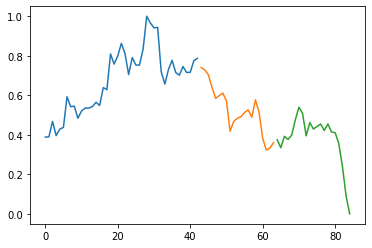

In [30]:
plt.plot(y_train, label='Train')
plt.plot(
    pd.Series(y_val,  index=range(train_size, train_size + val_size)), 
    label='Val')
plt.plot(
    pd.Series(y_test, index=range(train_size + val_size, train_size + test_size + val_size)),
    label='Test')
# plt.legend(loc='best')
plt.show()

# Ensemble

In [0]:
import random
random.seed(123)

In [0]:
def generator_mlp(x_train, y_train, x_val, y_val):   
    neuronios =  [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 170, 200]
    func_activation =  ['identity', 'tanh', 'relu']
    alg_treinamento = ['lbfgs', 'sgd', 'adam']
    max_iteracoes = [1000, 5000, 10000]
    learning_rate = ['constant', 'invscaling', 'adaptive']

    mlp = MLPRegressor(
        hidden_layer_sizes=random.choice(neuronios),
        activation=random.choice(func_activation),
        solver=random.choice(alg_treinamento),
        max_iter=random.choice(max_iteracoes),
        learning_rate=random.choice(learning_rate)
    )

    mlp.fit(x_train, y_train)
    predict_validation = mlp.predict(x_val)
    mse = MSE(y_val, predict_validation) 
    
    return mlp, mse

In [0]:
def bagging(x_train, y_train, x_val, y_val, n_estimators=20, percent=0.7):
  size = len(x_train)
  n_sample = int(size * percent)
  indexs = random.sample(range(size), n_sample)

  x_train_bagging = x_train[indexs]
  y_train_bagging = y_train[indexs]

  ensemble={}
  for i in range(n_estimators):
    model, mse = generator_mlp(x_train_bagging, y_train_bagging, x_val, y_val)
    ensemble[model] = mse

  return ensemble

In [0]:
def ensemble_predict(x, ensemble, method='average'):
  predictions = []
  for model in ensemble.keys():
    predictions.append(model.predict(x))
  
  if method == 'median':
    return np.median(predictions, axis=0)

  return np.mean(predictions, axis=0)

In [41]:
ensemble = bagging(x_train, y_train, x_val, y_val)
ensemble

{MLPRegressor(activation='identity', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=150, learning_rate='constant',
              learning_rate_init=0.001, max_iter=10000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False): 0.00618462750402302,
 MLPRegressor(activation='identity', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=30, learning_rate='invscaling',
              learning_rate_init=0.001, max_iter=5000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=F

In [44]:
ensemble_predict_med = ensemble_predict(x_test, ensemble, method='median')
ensemble_predict_med

array([0.50602428, 0.50881847, 0.48739589, 0.49110602, 0.50448402,
       0.45601743, 0.51879307, 0.52687318, 0.5137847 , 0.45639934,
       0.51056754, 0.48954974, 0.48925921, 0.50804475, 0.51665548,
       0.51999297, 0.55144214, 0.48880669, 0.46984967, 0.46101562,
       0.41965811])

In [43]:
ensemble_predict_avg = ensemble_predict(x_test, ensemble)
ensemble_predict_avg

array([0.49253426, 0.49271186, 0.48174667, 0.48517702, 0.50093147,
       0.45796612, 0.47108853, 0.486619  , 0.48714365, 0.46737073,
       0.49363458, 0.49225595, 0.48601349, 0.52024985, 0.50513226,
       0.52494855, 0.52681799, 0.50171269, 0.47895928, 0.43748963,
       0.38038577])

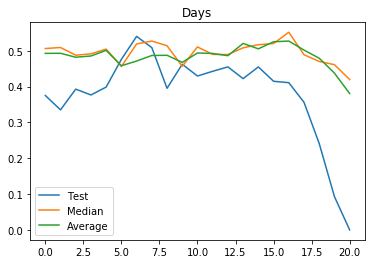

In [48]:
plt.plot(y_test, label='Test')
plt.plot(ensemble_predict_med, label='Median')
plt.plot(ensemble_predict_avg, label='Average')
plt.title('Days')
plt.legend()
plt.show()

In [39]:
np.mean([[1, 2, 3], [3, 2, 1]], axis=0)

array([2., 2., 2.])